[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanharvey1/neuro_py/blob/main/tutorials/attractor_landscape.ipynb)
&nbsp;
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ryanharvey1/neuro_py/main/tutorials/attractor_landscape.ipynb)
&nbsp;
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanharvey1/neuro_py/main?labpath=tutorials%2Fattractor_landscape.ipynb)


# Attractor Estimation

This tutorial demonstrates how to estimate potential energy landscapes for
simulated dynamical systems with attractors in one, two, three, and higher
dimensions. The goal is to understand the dynamics of systems governed by these
landscapes and validate estimations against the ground truth.

---


## Setup


In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import napari
import scipy
import sklearn
import sklearn.decomposition

from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from napari_animation import Animation

import neuro_py as npy

## Section 1: 1D Energy Landscape

This section focuses on simulating and estimating a 1D energy landscape to
provide a foundational understanding of attractor dynamics in a simple setting.


### Section 1.1: Simulate trials of 1D activity using Langevin dynamics with noise

We simulate the dynamics of particles (or neural states) evolving under a 1D
potential landscape influenced by noise. The dynamics are modeled using Langevin
equations with parameters for attractor depths, positions, and noise.

**Goals**:

- To visualize particle dynamics under a simple potential landscape.
- To understand how initial states and noise affects convergence to attractors
  and hence their estimation.

**Key Insights**:

- Particle trajectories converge to the minima of the potential wells,
  confirming the attractor dynamics.


In [ ]:
def gaussian(X, X0, sig, A):
    G = A * np.exp(-((X - X0) ** 2) / (2 * sig**2))
    dG = G * (X0 - X) / sig**2
    return -G, -dG


def mix_gaussians(X, Xp, a):
    u1, du1 = gaussian(X, Xp[0], 1, a[0])
    u2, du2 = gaussian(X, Xp[1], 1, a[1])
    u3, du3 = gaussian(X, Xp[2], 1, a[2])
    u = u1 + u2 + u3
    du = du1 + du2 + du3
    return u, du


def simulate_trials(Xp, a, num_trials, iterations, dt, noise_fac):
    """Simulate trials using Langevin dynamics with noise"""
    lan_fac = noise_fac * np.sqrt(dt)
    X_dyn = np.empty((num_trials, iterations))
    for i in range(num_trials):
        # random initial condition
        X_dyn[i, 0] = np.random.choice(Xp) + np.random.randn() * lan_fac
        for ii in range(iterations - 1):
            # energy and gradient at current position
            E, dE = mix_gaussians(X_dyn[i, ii], Xp, a)
            X_dyn[i, ii + 1] = X_dyn[i, ii] - dt * dE + lan_fac * np.random.randn()
    return X_dyn

Set parameters for the simulation generating the synthetic data influenced by
multiple bump attractors.


In [ ]:
Xp = [-2.5, 0, 2.5]  # positions of the minima of bump attractors
attractordepths = [0.25, 0.2, 0.25]

ntrials = 100
iterations = 5000
domain_bins = proj_bins = 100
dt = 0.1  # time step
noise_fac = 0.15  # noise factor

# generate data
X_dyn = simulate_trials(Xp, attractordepths, ntrials, iterations, dt, noise_fac)

### Section 1.2: Analytically estimate the 1D potential energy landscape

We analytically compute the 1D potential landscape and compare it to the
ground-truth potential used to generate the synthetic data.

**Goal**:

- To validate the simulation by comparing it to the analytical potential.

**Plot Descriptions**:

1. **Potential Landscape**: Displays the theoretical potential formed by the
   Gaussian mixture components.
2. **Dynamics of Trials**: Shows the temporal evolution of particle positions
   for selected trials.
3. **Potential Landscape Estimation**: Compares the analytical potential with
   the estimated potential.

**Key Insights**:

- The estimated potential closely matches the analytical potential, confirming
  the method's validity.


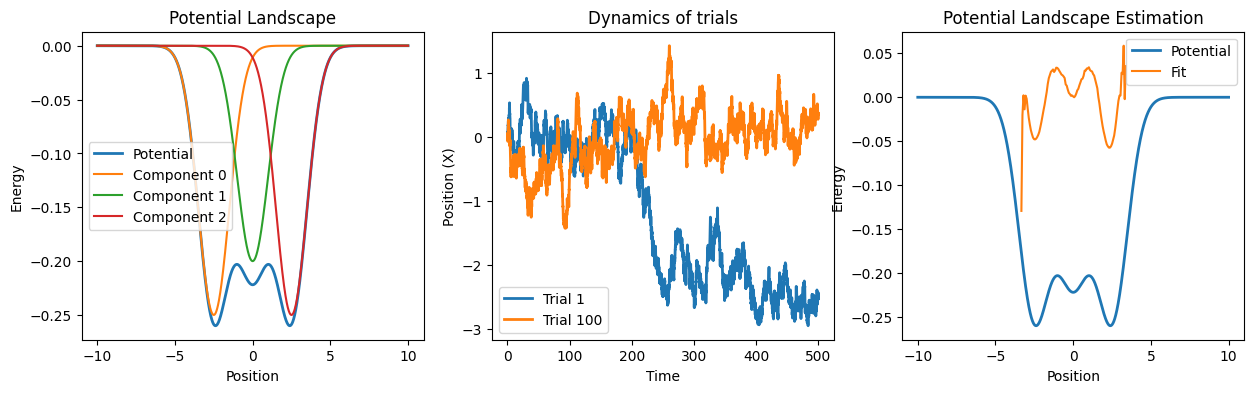

In [ ]:
potential_pos_t, grad_pos_t_svm, H, latentedges, domainedges = (
    npy.ensemble.potential_landscape(X_dyn, proj_bins, domain_bins)
)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
X = np.arange(-10, 10, 0.0025)

E, dE = mix_gaussians(X, Xp, attractordepths)
axes[0].plot(X, E, linewidth=2, label="Potential")
axes[0].set_title("Potential Landscape")
axes[0].set_xlabel("Position")
axes[0].set_ylabel("Energy")

for i in range(len(Xp)):
    axes[0].plot(
        X, gaussian(X, Xp[i], 1, attractordepths[i])[0], label=f"Component {i}"
    )
axes[0].legend()

T = np.arange(0, iterations * dt, dt)
axes[1].plot(T, X_dyn[0], linewidth=2, label="Trial 1")
axes[1].plot(T, X_dyn[-1], linewidth=2, label=f"Trial {ntrials}")
axes[1].set_title("Dynamics of trials")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Position (X)")
axes[1].legend()

axes[2].plot(X, E, linewidth=2, label="Potential")
axes[2].plot(latentedges[:-1], np.nanmean(potential_pos_t, axis=1), label="Fit")
axes[2].set_title("Potential Landscape Estimation")
axes[2].set_xlabel("Position")
axes[2].set_ylabel("Energy")
axes[2].legend()

plt.show()

## Section 2: 2D Energy Landscape

In this section, we extend the dynamics and estimation to two dimensions,
introducing more complexity.


### Section 2.1: Simulate trials of 2D activity using Langevin dynamics with noise

Simulate particle dynamics under a 2D potential landscape composed of Gaussian
attractors.

**Goal**:

- To explore how particle dynamics evolve in a 2D system with multiple
  attractors

**Key Insights**:

- Particle trajectories converge to minima in 2D, clustering around attractor
  states.


In [5]:
def gaussian_nd(X, X0, sig, A):  # -> tuple:
    """n-dimensional Gaussian function

    Parameters
    ----------
    X : np.ndarray
        n-dimensional grid space. Shape: (n_points, ndim).
    X0 : np.ndarray
        Centers of the Gaussian for each dimension (same shape as X).
    sig : np.ndarray or float
        Standard deviations for each dimension (either same shape as X or a single float).
    A : float
        Amplitude of the Gaussian.

    Returns
    -------
    G : np.ndarray
        Value of the n-dimensional Gaussian function at X.
    dG : np.ndarray
        Derivative of the n-dimensional Gaussian function along each dimension.
    """
    X = np.atleast_2d(X)
    X0 = np.atleast_1d(X0)
    sig = np.atleast_1d(sig)

    # Ensure X0 and sig are compatible with each dimension of the grid
    # assert len(X) == len(X0), "X0 should have the same number of dimensions as X"
    # assert len(X) == len(sig), "sig should have the same number of dimensions as X"

    # Compute the Gaussian function values across the grid
    exponent = -np.sum((X - X0) ** 2 / (2 * sig**2), axis=-1)
    G = A * np.exp(exponent)

    # Use np.gradient to compute the derivative along each axis
    dG = (((X0 - X) / sig**2).T * G).T  # shape: (n_points, ndim)

    return -G, -dG


def mix_functions(X, Xp, a, std=1, func=gaussian_nd):
    """Sum of Gaussians.

    Parameters
    ----------
    X : float
        Position
    Xp : list
        Centers of the Gaussians
    a : list
        Amplitudes of the Gaussians
    n : int
        Number of Gaussians

    Returns
    -------
    U : float
        Mixture of Gaussians
    dU : float
        Derivative of the mixture of Gaussians
    """
    for i, xp in enumerate(Xp):
        if i == 0:
            U, dU = func(X, xp, std, a[i])
        else:
            u, du = func(X, xp, std, a[i])
            U += u
            dU += du
    return U, dU


def simulate_trials(
    Xp,
    a,
    ntrials,
    iterations,
    dt,
    noise_fac,
    std=1,
    ngaussians=3,
    xstarts=None,
    func=gaussian_nd,
):
    """Simulate trials

    Parameters
    ----------
    Xp : list
        Centers of the Gaussians
    a : list
        Amplitudes of the Gaussians
    ntrials : int
        Number of trials
    iterations : int
        Number of iterations
    dt : float
        Time step
    noise_fac : float
        Noise factor

    Returns
    -------
    X_dyn : array
        Trajectories of the trials
    """
    nnrns = len(np.atleast_1d(Xp[0]))
    lan_fac = noise_fac * np.sqrt(dt)  # Langevin factor
    X_dyn = np.empty((ntrials, iterations, nnrns))  # Trajectories of the trials
    for i in range(ntrials):
        sel_ix = np.random.randint(len(Xp))
        if xstarts is None or len(xstarts) <= i:
            startstate = (
                Xp[sel_ix] + np.random.randn(*X_dyn[i, 0].shape) * lan_fac
            )  # random initial condition
        else:
            startstate = xstarts[i]
        X_dyn[i, 0] = startstate
        for ii in range(iterations - 1):
            E, dE = mix_functions(X_dyn[i, ii], Xp, a, std=std, func=func)
            X_dyn[i, ii + 1] = (
                X_dyn[i, ii] - dt * dE + lan_fac * np.random.randn(*dE.shape)
            )
    return X_dyn

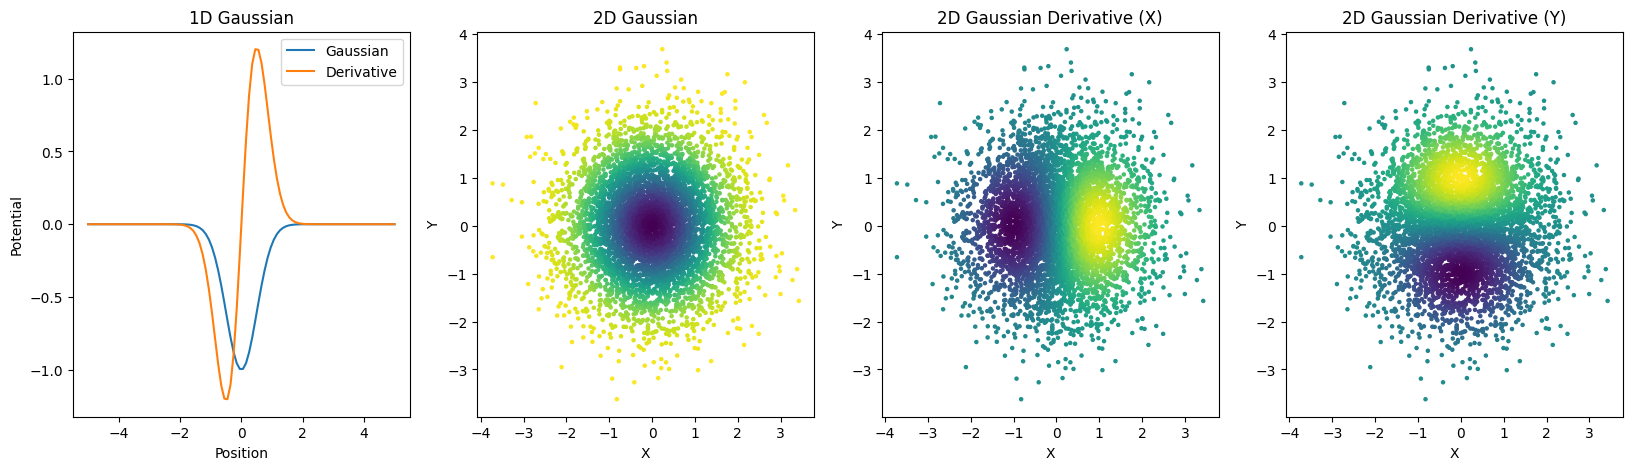

In [ ]:
Xp_1D = [0]  # Center of Gaussian
var_1D = 0.5  # Variance
X_1D = np.linspace(-5, 5, 100).reshape(-1, 1)  # 1D input points
A_1D = 1.0  # Amplitude

G_1D, dG_1D = gaussian_nd(X_1D, Xp_1D, var_1D, A_1D)

Xp_2D = [0, 0]
var_2D = 1
X_2D = np.random.randn(5000, 2)  # 2D input points
A_2D = 1.0  # Amplitude

G_2D, dG_2D = gaussian_nd(X_2D, Xp_2D, var_2D, A_2D)


fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].plot(X_1D, G_1D, label="Gaussian")
axes[0].plot(X_1D, dG_1D, label="Derivative")
axes[0].set_title("1D Gaussian")
axes[0].set_xlabel("Position")
axes[0].set_ylabel("Potential")
axes[0].legend()

axes[1].scatter(X_2D[:, 0], X_2D[:, 1], c=G_2D, cmap="viridis", s=5)

axes[1].set_title("2D Gaussian")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")

axes[2].scatter(X_2D[:, 0], X_2D[:, 1], c=dG_2D[:, 0], cmap="viridis", s=5)
axes[2].set_title("2D Gaussian Derivative (X)")
axes[2].set_xlabel("X")
axes[2].set_ylabel("Y")

axes[3].scatter(X_2D[:, 0], X_2D[:, 1], c=dG_2D[:, 1], cmap="viridis", s=5)
axes[3].set_title("2D Gaussian Derivative (Y)")
axes[3].set_xlabel("X")
axes[3].set_ylabel("Y")

plt.show()

Set parameters for the simulation generating the synthetic data influenced by
multiple bump attractors.

Note: We artificially create `xstarts` throughout different simulations to set
some of the initial states of the simulated trajectories to span the entire
space for better coverage, which is not necessary in real data and intelligent
initialization strategies can be used for simulations.


In [ ]:
Xp = np.asarray([[-2, -2], [0, 0], [2, 2]])
attractordepths = [0.25, 0.2, 0.25]

ntrials = 3000
iterations = 500
domain_bins = 20
proj_bins = 25

dt = 0.1  # time step
noise_fac = 0.1  # noise factor

# Generate starting points
posxstarts = np.linspace(-3.5, 3.5, 15)
xstarts = np.asarray(np.meshgrid(posxstarts, posxstarts)).T.reshape(-1, 2)
xstarts = np.repeat(xstarts, 5, axis=0)
np.random.shuffle(xstarts)

# Simulate dynamics
X_dyn = simulate_trials(
    Xp,
    attractordepths,
    ntrials,
    iterations,
    dt,
    noise_fac,
    ngaussians=len(Xp),
    xstarts=xstarts,
    std=1,
)

### Section 2.2: Analytically estimate the potential energy landscape

Compute and validate the 2D potential landscape using analytical and simulated
results.

**Plot Descriptions**:

1. **Potential Energy Landscape**: Visualizes the 2D attractor structure.
2. **Dynamics of Trials**: Shows particle trajectories across the 2D plane.
3. **Phase Plane**: Depicts vector fields indicating gradients toward attractor
   basins.
4. **Time-Resolved Potential Estimation**: Highlights temporal changes in the
   estimated landscape.

**Key Insights**:

- The agreement between the simulated dynamics and estimated landscapes
  demonstrates robustness in two dimensions.


In [ ]:
%matplotlib inline
potential_pos, potential_pos_t_nrns, grad_pos_t_svm, H, latentedges, domainedges = (
    npy.ensemble.potential_landscape_nd(
        X_dyn,
        [np.linspace(-3.5, 3.5, proj_bins), np.linspace(-3.5, 3.5, proj_bins)],
        domain_bins,
    )
)

X = np.linspace(-3.5, 3.5, proj_bins)
y = np.linspace(-3.5, 3.5, proj_bins)
X, Y = np.meshgrid(X, y)
X = np.stack((X, Y), axis=-1)
X = X.reshape(-1, 2)

E, dE = mix_functions(X, Xp, attractordepths, std=1, func=gaussian_nd)

gaussians_nd = []
for i in range(len(Xp)):
    gaussian = gaussian_nd(X, Xp[i], 1, attractordepths[i])[0].reshape(
        proj_bins, proj_bins
    )
    gaussian = (gaussian - np.min(gaussian)) / (np.max(gaussian) - np.min(gaussian))
    gaussians_nd.append(gaussian)
gaussians_nd = np.stack(gaussians_nd, axis=-1)


def simulate(t=0):
    fig = plt.figure(figsize=(17, 10))
    axes = []

    # make axes[0] 2D
    axes.append(fig.add_subplot(2, 3, 1))
    axes[-1].set_title("Potential Energy Landscape")
    axes[-1].set_xlabel("Position X")
    axes[-1].set_ylabel("Position Y")

    axes[-1].imshow(gaussians_nd[::-1])
    # add color label for each attractor outside the plot colored: red, green, blue
    colors = ["cyan", "magenta", "yellow"]
    for i, txt in enumerate(["Bump 1", "Bump 2", "Bump 3"]):
        axes[-1].text(gaussians_nd.shape[0], 2 * i, txt, color=colors[i])

    # make axes[1] 3D
    axes.append(fig.add_subplot(2, 3, 4, projection="3d"))
    X, Y = np.meshgrid(
        np.linspace(-3.5, 3.5, proj_bins), np.linspace(-3.5, 3.5, proj_bins)
    )
    axes[-1].plot_surface(X, Y, E.reshape(proj_bins, proj_bins), cmap="turbo")
    # plot the xstarts over the surface
    axes[-1].scatter(xstarts[:, 0], xstarts[:, 1], c="b", marker=".", alpha=0.05)
    axes[-1].set_xlabel("Position X")
    axes[-1].set_ylabel("Position Y")
    axes[-1].set_zlabel("Energy")

    axes.append(fig.add_subplot(2, 3, 2))
    for i in range(ntrials):
        axes[-1].plot(*(X_dyn[i].T), color="black", alpha=0.02)
    axes[-1].plot(*(X_dyn[0].T), linewidth=1, label="Trial 1", alpha=0.5)
    # start with green and end with red
    axes[-1].plot(*X_dyn[0, 0], "go", label="Start")
    axes[-1].plot(*X_dyn[0, -1], "rx", label="End")
    axes[-1].plot(*(X_dyn[-1].T), linewidth=1, label=f"Trial {ntrials}", alpha=0.5)
    axes[-1].plot(*X_dyn[-1, 0], "go")
    axes[-1].plot(*X_dyn[-1, -1], "rx")

    axes[-1].set_title("Dynamics of trials")
    axes[-1].set_xlabel("Position X")
    axes[-1].set_ylabel("Position Y")
    axes[-1].legend()

    axes.append(fig.add_subplot(2, 3, 3, projection="3d"))
    X, Y = np.meshgrid(latentedges[:-1, 0], latentedges[:-1, 0])
    axes[-1].plot_surface(X, Y, np.nanmean(potential_pos, axis=0), cmap="turbo")
    axes[-1].set_title("Potential Estimation")
    axes[-1].set_xlabel("Position X")
    axes[-1].set_ylabel("Position Y")
    axes[-1].set_zlabel("Energy")

    axes.append(fig.add_subplot(2, 3, 5))
    # plot vector field
    X, Y = np.meshgrid(latentedges[:-1, 0], latentedges[:-1, 0])
    U = grad_pos_t_svm[:, :, t, 0]
    V = grad_pos_t_svm[:, :, t, 1]
    axes[-1].quiver(X, Y, U, V)
    axes[-1].set_title("Phase plane")
    axes[-1].set_xlabel("Position X")
    axes[-1].set_ylabel("Position Y")

    axes.append(fig.add_subplot(2, 3, 6, projection="3d"))
    axes[-1].plot_surface(
        X, Y, np.nanmean(potential_pos_t_nrns[:, :, t], axis=-1), cmap="turbo"
    )
    axes[-1].set_title("Time-resolved Potential Estimation")
    axes[-1].set_xlabel("Position X")
    axes[-1].set_ylabel("Position Y")
    axes[-1].set_zlabel("Energy")

    plt.show()


_ = widgets.interact(simulate, t=(0, domain_bins - 1))

interactive(children=(IntSlider(value=0, description='t', max=19), Output()), _dom_classes=('widget-interact',…

Visualize the time-resolved potential estimation to observe how the landscape
evolves over time.


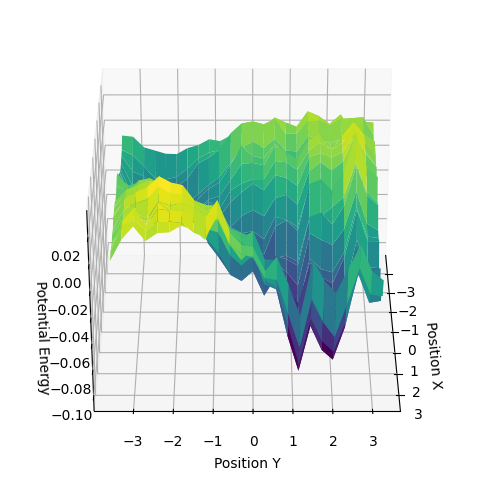

In [ ]:
t_steps = domain_bins  # Number of time steps


def update_surface(t, ax, surf):
    """
    Update the surface plot for time `t`.
    """
    X, Y = np.meshgrid(latentedges[:-1, 0], latentedges[:-1, 0])
    Z = -np.nanmean(
        np.asarray(
            [np.nancumsum(grad_pos_t_svm[:, :, t, nrn], axis=nrn) for nrn in range(2)]
        ),
        axis=0,
    )

    surf[0].remove()  # Remove old surface
    surf[0] = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none")


def animate(t):
    """
    Update the plot for frame t and rotate the view.
    """
    update_surface(t, ax, surf)
    ax.view_init(elev=30, azim=t * 360 / t_steps)  # Rotate azimuth over time


# Create figure and 3D plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(latentedges[:-1, 0], latentedges[:-1, 0])
Z = np.nanmean(potential_pos_t_nrns[:, :, 0], axis=-1)

surf = [ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none")]
ax.set_xlabel("Position X")
ax.set_ylabel("Position Y")
ax.set_zlabel("Potential Energy")

# Animate
anim = FuncAnimation(fig, animate, frames=t_steps, interval=100, blit=False)
HTML(anim.to_jshtml())

### Section 2.3: Simulate 2D trials for a ring attractor


We simulate a 2D system with a ring attractor, a special case where attractors
form a ring structure, defined by:

$$ \psi(x, y) = \frac{1}{\pi \sigma^4} (1 - \frac{x^2 + y^2}{2 _ \sigma^2}) {\rm e}^{-\frac{x^2 + y^2}{2 _ \sigma^2}}$$

where $\sigma$ is the standard deviation of the repulsive potential.

**Goal**:

- To understand how ring attractors influence particle dynamics.

**Key Insights**:

- Particles converge to the ring attractor, forming a stable ring structure.


In [ ]:
def mexican_hat_nd(X, X0, sig, A):
    """n-dimensional Mexican hat function

    Negative normalized second derivative of a Gaussian function.

    Parameters
    ----------
    X : np.ndarray
        n-dimensional grid space. Shape: (n_points, ndim).
    X0 : np.ndarray
        Centers of the Mexican hat for each dimension (same shape as X).
    sig : np.ndarray or float
        Standard deviations for each dimension (either same shape as X or a single float).
    A : float
        Amplitude of the Mexican hat.

    Returns
    -------
    G : np.ndarray
        Value of the n-dimensional Mexican hat function at X.
    dG : np.ndarray
        Derivative of the n-dimensional Mexican hat function along each dimension.
    """
    X = np.atleast_2d(X)
    X0 = np.atleast_1d(X0)
    sig = np.atleast_1d(sig)

    # Compute the Mexican hat function values across the grid
    exponent = np.sum((X - X0) ** 2 / (2 * sig**2), axis=-1)
    M = A * (1 - exponent) * np.exp(-exponent) / sig**4

    dM = -(
        ((X - X0) / (np.pi * sig**6)).T * np.exp(-exponent) * (2 - exponent)
    ).T  # shape: (n_points, ndim)

    return M, dM

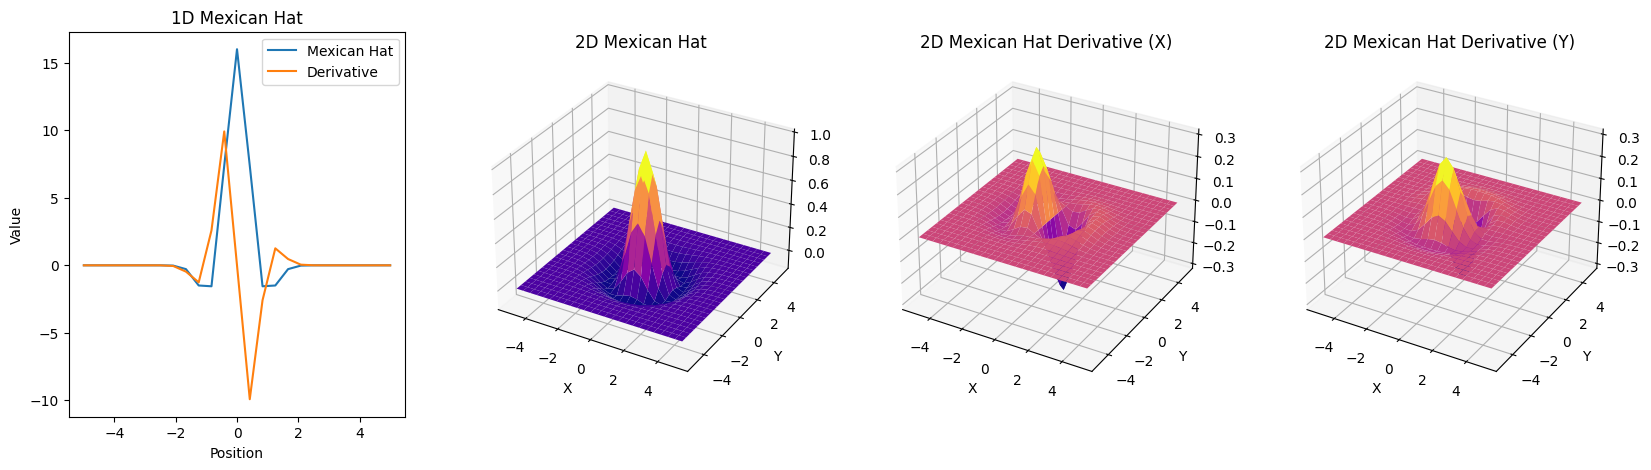

In [ ]:
Xp_1D = [0]  # Center of Gaussian
cov_1D = 0.5  # Variance
X_1D = np.linspace(-5, 5, proj_bins).reshape(-1, 1)  # 1D input points
A_1D = 1.0  # Amplitude

G_1D, dG_1D = mexican_hat_nd(X_1D, Xp_1D, cov_1D, A_1D)

Xp_2D = [0, 0]
X_2D = 3 * np.random.randn(7500, 2)  # 2D input points
A_2D = 1.0  # Amplitude

G_2D, dG_2D = mexican_hat_nd(X_2D, Xp_2D, 1, A_2D)


fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.ravel()

axes[0].plot(X_1D, G_1D, label="Mexican Hat")
axes[0].plot(X_1D, dG_1D.ravel(), label="Derivative")
axes[0].set_title("1D Mexican Hat")
axes[0].set_xlabel("Position")
axes[0].set_ylabel("Value")
axes[0].legend()

axes[1].remove()
axes[1] = fig.add_subplot(1, 4, 2, projection="3d")
X, Y = np.meshgrid(X_1D, X_1D)
X_in = np.stack((X, Y), axis=-1)
X_in = X_in.reshape(-1, 2)
# test mexican hat once
axes[1].plot_surface(
    X,
    Y,
    mexican_hat_nd(X_in, [0, 0], 1, 1)[0].reshape(proj_bins, proj_bins),
    cmap="plasma",
)

axes[1].set_title("2D Mexican Hat")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")

axes[2].remove()
axes[2] = fig.add_subplot(1, 4, 3, projection="3d")
axes[2].plot_surface(
    X,
    Y,
    mexican_hat_nd(X_in, [0, 0], 1, 1)[1][:, 0].reshape(proj_bins, proj_bins),
    cmap="plasma",
)
axes[2].set_title("2D Mexican Hat Derivative (X)")
axes[2].set_xlabel("X")
axes[2].set_ylabel("Y")

axes[3].remove()
axes[3] = fig.add_subplot(1, 4, 4, projection="3d")
axes[3].plot_surface(
    X,
    Y,
    mexican_hat_nd(X_in, [0, 0], 1, 1)[1][:, 1].reshape(proj_bins, proj_bins),
    cmap="plasma",
)
axes[3].set_title("2D Mexican Hat Derivative (Y)")
axes[3].set_xlabel("X")
axes[3].set_ylabel("Y")


plt.show()

In [ ]:
Xp = np.asarray([[0, 0]])
attractordepths = [0.25]

ntrials = 3000
iterations = 100
domain_bins = 20
proj_bins = 25
dt = 0.2  # time step
noise_fac = 0.1  # noise factor

# Generate starting points
posxstarts = np.linspace(-3.5, 3.5, 15)
xstarts = np.asarray(np.meshgrid(posxstarts, posxstarts)).T.reshape(-1, 2)
xstarts = np.repeat(xstarts, 5, axis=0)
np.random.shuffle(xstarts)

# Simulate dynamics
X_dyn = simulate_trials(
    Xp,
    attractordepths,
    ntrials,
    iterations,
    dt,
    noise_fac,
    ngaussians=len(Xp),
    xstarts=xstarts,
    func=mexican_hat_nd,
)

### Section 2.4: Analytically estimate the potential energy landscape

Estimate the potential landscape for the ring attractor and compare it to the
ground-truth potential.

**Plot Descriptions**:

1. **Potential Energy Landscape**: Displays the ring attractor structure.
2. **Dynamics of Trials**: Shows particle trajectories in the 2D plane.
3. **Phase Plane**: Depicts vector fields indicating gradients toward the ring
   attractor.
4. **Time-Resolved Potential Estimation**: Highlights temporal changes in the
   estimated landscape.

**Key Insights**:

- The estimated potential closely matches the analytical potential, confirming
  the method's validity.


In [ ]:
%matplotlib inline
potential_pos, potential_pos_t_nrns, grad_pos_t_svm, H, latentedges, domainedges = (
    npy.ensemble.potential_landscape_nd(
        X_dyn,
        [np.linspace(-3.5, 3.5, proj_bins), np.linspace(-3.5, 3.5, proj_bins)],
        domain_bins,
    )
)

X = np.linspace(-3.5, 3.5, proj_bins)
y = np.linspace(-3.5, 3.5, proj_bins)
X, Y = np.meshgrid(X, y)
X = np.stack((X, Y), axis=-1)
X = X.reshape(-1, 2)

E, dE = mix_functions(X, Xp, attractordepths, func=mexican_hat_nd)

gaussians_nd = []
for i in range(len(Xp)):
    gaussian = mexican_hat_nd(X, Xp[i], 1, attractordepths[i])[0].reshape(
        proj_bins, proj_bins
    )
    gaussian = (gaussian - np.min(gaussian)) / (np.max(gaussian) - np.min(gaussian))
    gaussians_nd.append(gaussian)
gaussians_nd = np.stack(gaussians_nd, axis=-1)


def simulate(t=0):
    fig = plt.figure(figsize=(17, 10))
    axes = []

    # make axes[0] 2D
    axes.append(fig.add_subplot(2, 3, 1))
    axes[-1].set_title("Potential Energy Landscape")
    axes[-1].set_xlabel("Position X")
    axes[-1].set_ylabel("Position Y")

    axes[-1].imshow(gaussians_nd[::-1], cmap="turbo")

    # make axes[1] 3D
    axes.append(fig.add_subplot(2, 3, 4, projection="3d"))
    X, Y = np.meshgrid(
        np.linspace(-3.5, 3.5, proj_bins), np.linspace(-3.5, 3.5, proj_bins)
    )
    axes[-1].plot_surface(X, Y, E.reshape(proj_bins, proj_bins), cmap="turbo")
    axes[-1].set_xlabel("Position X")
    axes[-1].set_ylabel("Position Y")
    axes[-1].set_zlabel("Energy")

    axes.append(fig.add_subplot(2, 3, 2))
    for i in range(ntrials):
        axes[-1].plot(*(X_dyn[i].T), color="black", alpha=0.02)
    axes[-1].plot(*(X_dyn[0].T), linewidth=1, label="Trial 1", alpha=0.5)
    # start with green and end with red
    axes[-1].plot(*X_dyn[0, 0], "go", label="Start")
    axes[-1].plot(*X_dyn[0, -1], "rx", label="End")
    axes[-1].plot(*(X_dyn[-1].T), linewidth=1, label=f"Trial {ntrials}", alpha=0.5)
    axes[-1].plot(*X_dyn[-1, 0], "go")
    axes[-1].plot(*X_dyn[-1, -1], "rx")

    axes[-1].set_title("Dynamics of trials")
    axes[-1].set_xlabel("Position X")
    axes[-1].set_ylabel("Position Y")
    axes[-1].legend()

    axes.append(fig.add_subplot(2, 3, 3, projection="3d"))
    X, Y = np.meshgrid(latentedges[:-1, 0], latentedges[:-1, 0])

    axes[-1].plot_surface(X, Y, np.nanmean(potential_pos, axis=0), cmap="turbo")
    axes[-1].set_title("Potential Estimation")
    axes[-1].set_xlabel("Position X")
    axes[-1].set_ylabel("Position Y")
    axes[-1].set_zlabel("Energy")

    axes.append(fig.add_subplot(2, 3, 5))
    # plot vector field
    X, Y = np.meshgrid(latentedges[:-1, 0], latentedges[:-1, 0])
    U = grad_pos_t_svm[:, :, t, 0]
    V = grad_pos_t_svm[:, :, t, 1]
    axes[-1].quiver(X, Y, U, V)
    axes[-1].set_title("Phase plane")
    axes[-1].set_xlabel("Position X")
    axes[-1].set_ylabel("Position Y")

    axes.append(fig.add_subplot(2, 3, 6, projection="3d"))
    X, Y = np.meshgrid(latentedges[:-1, 0], latentedges[:-1, 0])

    axes[-1].plot_surface(
        X, Y, np.nanmean(potential_pos_t_nrns[:, :, t], axis=-1), cmap="turbo"
    )
    axes[-1].set_title("Time-resolved Potential Estimation")
    axes[-1].set_xlabel("Position X")
    axes[-1].set_ylabel("Position Y")
    axes[-1].set_zlabel("Energy")

    plt.show()


_ = widgets.interact(simulate, t=(0, domain_bins - 1))

interactive(children=(IntSlider(value=0, description='t', max=19), Output()), _dom_classes=('widget-interact',…

Visualize the time-resolved potential estimation for the ring attractor.


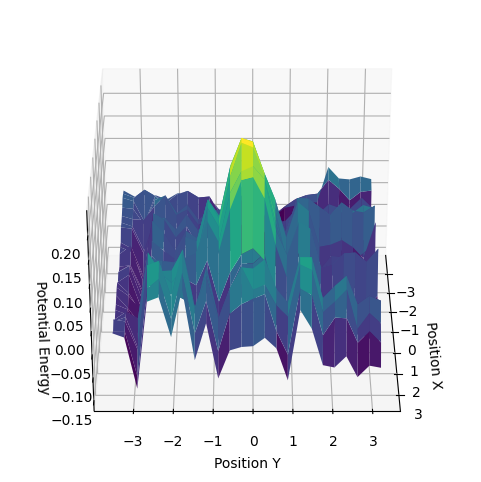

In [ ]:
from matplotlib.animation import FuncAnimation

# Dummy data to simulate inputs
t_steps = domain_bins  # Number of time steps


def animate(t):
    """
    Update the plot for frame t and rotate the view.
    """
    update_surface(t, ax, surf)
    ax.view_init(elev=30, azim=t / 2 * 360 / t_steps)  # Rotate azimuth over time


# Create figure and 3D plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(latentedges[:-1, 0], latentedges[:-1, 0])
Z = np.nanmean(potential_pos_t_nrns[:, :, 0], axis=-1)

surf = [ax.plot_surface(X, Y, Z, cmap="turbo", edgecolor="none")]
ax.set_xlabel("Position X")
ax.set_ylabel("Position Y")
ax.set_zlabel("Potential Energy")

# Animate
anim = FuncAnimation(fig, animate, frames=t_steps, interval=100, blit=False)
HTML(anim.to_jshtml())

---


## Section 3: 3D Energy Landscape

This section explores the dynamics and estimation of potential landscapes in
three dimensions.


### Section 3.1: Simulate 3D trials using Langevin dynamics with noise

Simulate 3D dynamics under Gaussian attractors to examine the additional
complexity introduced by higher dimensions.

**Purpose**:

- To study how particle trajectories behave in a 3D space with noise.

**Plot Descriptions**:

- **Dynamics of Trials**: Shows particle trajectories in the 3D space.

**Key Insights**:

- Trajectories exhibit complex convergence patterns due to added dimensionality.


In [ ]:
Xp = np.asarray(
    [
        [-1.5, -1.5, -1.5],
        [0, 0, 0],
        [1.5, 1.5, 1.5],
    ]
)
attractordepths = [1, 0.95, 1]

ntrials = 5000
iterations = 500
domain_bins = 20
proj_bins = 20
dt = 0.1  # time step
noise_fac = 0.05  # noise factor
attractorfunc = gaussian_nd

# Generate starting points
posxstarts = np.linspace(-3.5, 3.5, 30)
xstarts = np.asarray(np.meshgrid(posxstarts, posxstarts, posxstarts)).T.reshape(-1, 3)
xstarts = np.repeat(xstarts, 1, axis=0)
np.random.shuffle(xstarts)

# Simulate dynamics
X_dyn = simulate_trials(
    Xp,
    attractordepths,
    ntrials,
    iterations,
    dt,
    noise_fac,
    ngaussians=len(Xp),
    xstarts=xstarts,
    func=attractorfunc,
    std=1,
)  # shape: (ntrials, iterations, 3)

In [ ]:
# convert X_dyn to 2D with columns as (trial number, time step, x, y, z)
X_dyn_2D = np.concatenate(
    [
        np.repeat(np.arange(ntrials), iterations).reshape(-1, 1),
        np.broadcast_to(np.arange(iterations), (ntrials, iterations))
        .flatten()
        .reshape(-1, 1),
        X_dyn.reshape(-1, 3),
    ],
    axis=1,
)

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_tracks(X_dyn_2D, tail_width=1, name="Dynamics of trials")

animation = Animation(viewer)
viewer.update_console({"animation": animation})

viewer.camera.angles = (0.0, 0.0, 90.0)
animation.capture_keyframe()
max_steps = int(viewer.dims.range[0][1])
# rotate the camera 360 degrees while advancing the time
for i in range(0, max_steps, 3):
    angle_inc = i * 360 / max_steps
    viewer.camera.angles = (
        0.0 + 0.075 * angle_inc,
        0.0 + angle_inc,
        90.0 + 0.1 * angle_inc,
    )
    viewer.dims.current_step = (i, *viewer.dims.current_step[1:])
    animation.capture_keyframe(steps=1)

animation.animate("anim3DTrajs.mp4", canvas_only=True)

HTML('<video controls src="anim3DTrajs.mp4" />')

Rendering frames...


100%|██████████| 168/168 [00:38<00:00,  4.34it/s]


### Section 3.2: Analytically estimate the potential energy landscape

Visualize and validate the estimated 3D landscape against the analytical
potential.

**Plot Descriptions**:

- **Potential Energy Landscape**: Displays the 3D attractor structure.
- **Time-Resolved Potential Estimation**: Highlights temporal changes in the
  estimated landscape.

**Key Insights**:

- The estimated potential closely matches the analytical potential, confirming
  the method's validity.


In [ ]:
%matplotlib inline
pot_timeaveraged, potential_pos_t_nrns, grad_pos_t_svm, H, latentedges, domainedges = (
    npy.ensemble.potential_landscape_nd(
        X_dyn,
        [
            np.linspace(-3.5, 3.5, proj_bins),
            np.linspace(-3.5, 3.5, proj_bins),
            np.linspace(-3.5, 3.5, proj_bins),
        ],
        domain_bins,
        nanborderempty=True,
    )
)

X = np.linspace(-3.5, 3.5, proj_bins)
y = np.linspace(-3.5, 3.5, proj_bins)
X, Y, Z = np.meshgrid(X, y, y)
X = np.stack((X, Y, Z), axis=-1)
X = X.reshape(-1, 3)

E, dE = mix_functions(X, Xp, attractordepths, func=mexican_hat_nd)

gaussians_nd = []
for i in range(len(Xp)):
    gaussian = attractorfunc(X, Xp[i], 1, attractordepths[i])[0].reshape(
        proj_bins, proj_bins, proj_bins
    )
    gaussian = (gaussian - np.max(gaussian)) / (np.max(gaussian) - np.min(gaussian)) + 1
    gaussians_nd.append(gaussian)
gaussians_nd = np.stack(gaussians_nd, axis=-1)

Potential energy landscape averaged over time provide a clearer view of the
attractor structure.


In [ ]:
viewer = napari.Viewer(ndisplay=3)

viewer.add_image(
    np.nanmean(pot_timeaveraged, axis=0),
    colormap="twilight",
    interpolation2d="nearest",
    rendering="minip",
    name="Estimated Potential Energy Landscape",
)

viewer.add_image(
    gaussians_nd.mean(-1),
    colormap="twilight",
    interpolation2d="nearest",
    rendering="minip",
    name="Original Potential Energy Landscape",
)

# grid view
viewer.grid.enabled = True

# napari.utils.nbscreenshot(viewer, canvas_only=True)

animation = Animation(viewer)
viewer.update_console({"animation": animation})

viewer.camera.angles = (0.0, 0.0, 90.0)
animation.capture_keyframe()
max_steps = 360
# rotate the camera 360 degrees while advancing the time
for i in range(0, max_steps, 3):
    angle_inc = i * 360 / max_steps
    viewer.camera.angles = (
        0.0 + 0.01 * angle_inc,
        0.0 + 0.02 * angle_inc,
        90.0 + angle_inc,
    )
    animation.capture_keyframe(steps=1)

animation.animate("anim3DPot.mp4", canvas_only=True)

HTML('<video controls src="anim3DPot.mp4" />')

Rendering frames...


  0%|          | 0/121 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1307, 808) to (1312, 816) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x64e2300] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 121/121 [00:01<00:00, 66.71it/s]


Time-resolved potential estimation visualizes the evolution of the landscape
over time.


In [ ]:
viewer = napari.Viewer(ndisplay=3)
pot_timeresolved = np.nanmean(
    np.asarray(
        [
            potential_pos_t_nrns[:, :, :, :, nrn]
            for nrn in range(potential_pos_t_nrns.shape[-1])
        ]
    ),
    axis=0,
)

viewer.add_image(
    pot_timeresolved.T,
    colormap="twilight",
    interpolation="nearest",
    rendering="minip",
    name="Estimated Potential Energy Landscape",
)

# grid view
viewer.grid.enabled = True

# napari.utils.nbscreenshot(viewer, canvas_only=True)

animation = Animation(viewer)
viewer.update_console({"animation": animation})

viewer.camera.angles = (0.0, 0.0, 90.0)
animation.capture_keyframe()
max_steps = int(viewer.dims.range[0][1])
# rotate the camera 360 degrees while advancing the time
for i in np.linspace(0, max_steps - 1, max_steps * 4):
    angle_inc = i * 360 / max_steps
    viewer.camera.angles = (
        0.0 + 0.075 * angle_inc,
        0.0 + angle_inc,
        90.0 + 0.1 * angle_inc,
    )
    viewer.dims.current_step = (i, *viewer.dims.current_step[1:])
    animation.capture_keyframe(steps=1)

animation.animate("anim3DPotTimeResolved.mp4", canvas_only=True)

HTML('<video controls src="anim3DPotTimeResolved.mp4" />')

/tmp/ipykernel_208666/2859654884.py:7: DeprecationWarning: Argument 'interpolation' is deprecated, please use 'interpolation2d' instead. The argument 'interpolation' was deprecated in 0.4.17 and it will be removed in 0.6.0.
  viewer.add_image(pot_timeresolved.T, colormap='twilight', interpolation='nearest', rendering='minip',


Rendering frames...


  0%|          | 0/81 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1307, 786) to (1312, 800) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x59a91c0] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 81/81 [00:01<00:00, 75.12it/s]


### Section 3.3: Potential energy landscape dimensionality reduction via PCA

PCA is used to reduce the dimensionality of energy landscapes for better
visualization and analysis.

**Purpose**:

- To simplify the representation of high-dimensional landscapes.

**Key Insights**:

- PCA-projected landscapes retain essential attractor characteristics.


In [ ]:
# Do PCA on the data
pca = sklearn.decomposition.PCA(n_components=2)
X_dyn_pca = pca.fit_transform(X_dyn_2D[:, 2:])

viewer = napari.Viewer(ndisplay=2)
viewer.add_tracks(
    np.hstack((X_dyn_2D[:, :2], X_dyn_pca)), tail_width=1, name="Dynamics of trials"
)

<Tracks layer 'Dynamics of trials' at 0x7294c10ae880>

In [ ]:
def project_ndimage(
    pot, proj_bins, pca
):  # -> NDArray:# -> NDArray:# -> NDArray:# -> list:
    """
    Compute the projected potentials in a reduced PCA space.

    Parameters
    ----------
    pot : list of np.ndarray
        List of potential landscapes for each neuron, where each element is an n-dimensional array.
    proj_bins : int
        Number of bins for projecting the data into reduced dimensions.
    pca : sklearn.decomposition.PCA
        PCA object to transform high-dimensional data to lower dimensions.

    Returns
    -------
    pot_pos_projs : list of np.ndarray
        List of projected potentials in the PCA-reduced space for each neuron.
    """
    nnrns = len(pot)  # Number of neurons
    ndim = pot[0].ndim  # Dimensionality of the potential landscape

    # Flatten potential landscapes into a table
    indices = np.indices(pot[0].shape).reshape(ndim, -1).T
    pots_table = np.empty((len(indices), nnrns), dtype=float)
    for ix, ndix in enumerate(indices):
        pots_table[ix] = [pot[nrn][tuple(ndix)] for nrn in range(nnrns)]

    # Prepare grid for PCA transformation
    X = np.linspace(-3, 3, proj_bins)
    mid_points = (X[1:] + X[:-1]) / 2  # Midpoints of the bins
    grid = np.meshgrid(*[mid_points for _ in range(ndim)])
    X = np.stack(grid, axis=-1).reshape(-1, ndim)

    # Transform high-dimensional grid to PCA space
    ndspace_proj = pca.transform(X)

    # Handle NaN values in the potentials table
    pots_table[np.isnan(pots_table)] = 0

    # Project potentials into PCA space
    pot_pos_projs = []
    for nrn in range(nnrns):
        # Compute the binned statistics
        pot_pos_proj = scipy.stats.binned_statistic_dd(
            ndspace_proj, pots_table[:, nrn], statistic="sum", bins=proj_bins
        ).statistic

        # Count occurrences in each bin
        H = scipy.stats.binned_statistic_dd(
            ndspace_proj, pots_table[:, nrn], statistic="count", bins=proj_bins
        ).statistic

        # Normalize and handle division by zero
        pot_pos_proj = np.divide(pot_pos_proj, H, where=H != 0)
        pot_pos_proj[H == 0] = np.nan  # Assign NaN to empty bins

        pot_pos_projs.append(pot_pos_proj)
    pot_pos_projs = np.asarray(pot_pos_projs)

    return pot_pos_projs

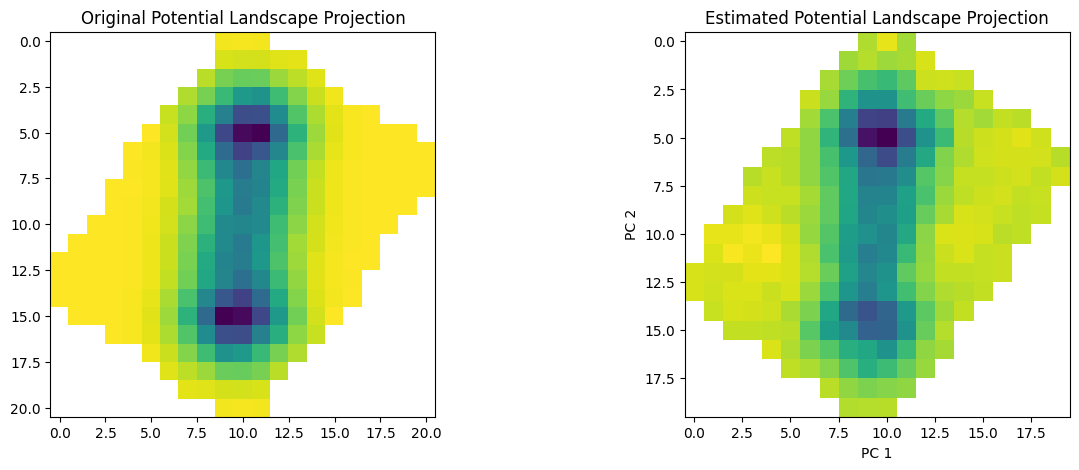

In [ ]:
# project potential landscape to 2D
est_pot = np.asarray(
    [np.mean(potential_pos_t_nrns[:, :, :, nrn], axis=-1) for nrn in range(3)]
)

est_pot_pos_projs = project_ndimage(est_pot, proj_bins, pca)

orig_pot_pos_projs = project_ndimage(gaussians_nd.T, proj_bins + 1, pca)

est_pot_pos_projs = project_ndimage(est_pot, proj_bins, pca)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(np.nanmean(orig_pot_pos_projs, axis=0))
axes[0].set_title("Original Potential Landscape Projection")
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 2")
axes[1].imshow(np.nanmean(est_pot_pos_projs, axis=0))
axes[1].set_title("Estimated Potential Landscape Projection")
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 2")

plt.show()

## Section 4: n-dimensional Energy Landscape


### Section 4.1: Simulate n-dimensional trials using Langevin dynamics with noise

Simulate particle dynamics in an n-dimensional landscape to study the
scalability of the methods.

**Purpose**:

- To test how well the simulation and estimation approaches scale with
  dimensionality.

**Key Insights**:

- Higher-dimensional systems pose challenges in visualization and computational
  requirements.


In [ ]:
ndim = 4
Xp = np.asarray([np.ones(ndim) * 1.5, np.zeros(ndim), np.ones(ndim) * -1.5])
attractordepths = [1, 0.95, 1]

ntrials = 1000
iterations = 500
domain_bins = 20
proj_bins = 20
dt = 0.1  # time step
noise_fac = 0.05  # noise factor
attractorfunc = gaussian_nd

# Generate starting points
posxstarts = np.linspace(-3, 3, 8)
xstarts = np.asarray(np.meshgrid(*[posxstarts] * ndim)).T.reshape(-1, ndim)
xstarts = np.repeat(xstarts, 2, axis=0)
np.random.shuffle(xstarts)

# Simulate dynamics
X_dyn = simulate_trials(
    Xp,
    attractordepths,
    ntrials,
    iterations,
    dt,
    noise_fac,
    ngaussians=len(Xp),
    xstarts=xstarts,
    func=attractorfunc,
    std=1,
)  # shape: (ntrials, iterations, 30)

In [ ]:
# convert X_dyn to 2D with columns as (trial number, time step, x, y, z)
# Reduce high-dimensional data using PCA
pca = sklearn.decomposition.PCA(n_components=3)

X_dyn_tabular = np.concatenate(
    [
        np.repeat(np.arange(ntrials), iterations).reshape(-1, 1),
        np.broadcast_to(np.arange(iterations), (ntrials, iterations))
        .flatten()
        .reshape(-1, 1),
        pca.fit_transform(X_dyn.reshape(-1, ndim)),
    ],
    axis=1,
)

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_tracks(X_dyn_tabular, tail_width=1, name="Dynamics of trials")

animation = Animation(viewer)
viewer.update_console({"animation": animation})

viewer.camera.angles = (0.0, 0.0, 90.0)
animation.capture_keyframe()
max_steps = int(viewer.dims.range[0][1])
# rotate the camera 360 degrees while advancing the time
for i in range(0, max_steps, 3):
    angle_inc = i * 360 / max_steps
    viewer.camera.angles = (
        0.0 + 0.075 * angle_inc,
        0.0 + angle_inc,
        90.0 + 0.1 * angle_inc,
    )
    viewer.dims.current_step = (i, *viewer.dims.current_step[1:])
    animation.capture_keyframe(steps=1)

animation.animate(f"anim{ndim}DTrajs.mp4", canvas_only=True)

HTML(f'<video controls src="anim{ndim}DTrajs.mp4" />')

Rendering frames...


  0%|          | 0/168 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1322, 786) to (1328, 800) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6c1c300] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 168/168 [00:08<00:00, 18.73it/s]


### Section 4.2: Analytically estimate the potential energy landscape

Validate the estimated n-dimensional potential against theoretical predictions
using dimensionality reduction techniques like PCA.

**Key Insights**:

- Projected landscapes in PCA space confirm the validity of estimations in
  high-dimensional systems.


In [ ]:
(
    potential_timeaveraged,
    potential_pos_t_nrns,
    grad_pos_t_svm,
    H,
    latentedges,
    domainedges,
) = npy.ensemble.potential_landscape_nd(
    X_dyn,
    [np.linspace(-3, 3, proj_bins) for i in range(ndim)],
    domain_bins,
    nanborderempty=True,
)

X = np.linspace(-3, 3, proj_bins)
X = np.meshgrid(*[X for _ in range(ndim)])
X = np.stack(X, axis=-1)
X = X.reshape(-1, ndim)

E, dE = mix_functions(X, Xp, attractordepths, func=attractorfunc)

gaussians_nd = []
for i in range(len(Xp)):
    gaussian = attractorfunc(X, Xp[i], 1, attractordepths[i])[0].reshape(
        *[proj_bins for _ in range(ndim)]
    )
    gaussian = (gaussian - np.max(gaussian)) / (np.max(gaussian) - np.min(gaussian)) + 1
    gaussians_nd.append(gaussian)
gaussians_nd = np.stack(gaussians_nd, axis=-1)

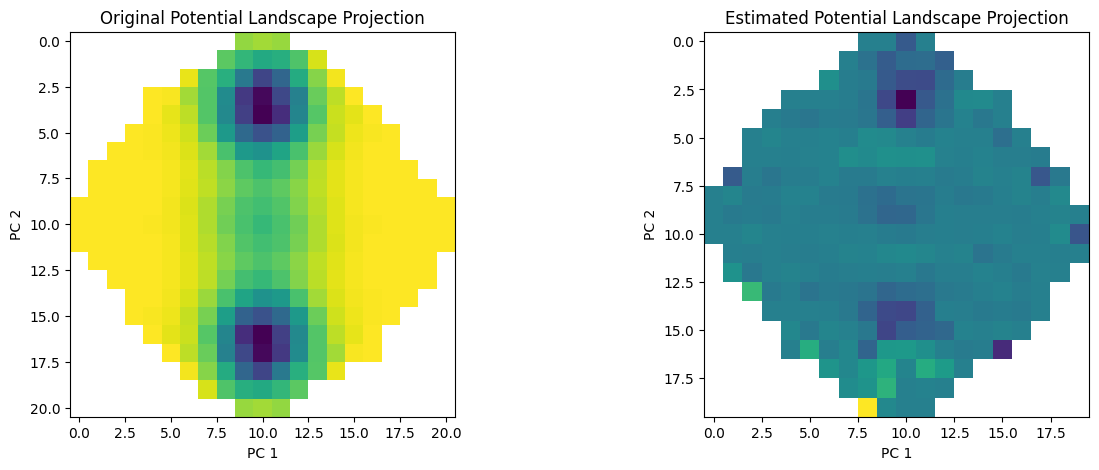

In [ ]:
orig_pot_pos_projs = project_ndimage(gaussians_nd.T, proj_bins + 1, pca)

# avoid RuntimeWarning: Mean of empty slice
est_pot = np.asarray(
    [
        np.nanmean(potential_pos_t_nrns[:, :, :, :, :, nrn], axis=-1)
        for nrn in range(ndim)
    ]
)
est_pot_pos_projs = project_ndimage(est_pot, proj_bins, pca)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(np.nanmean(np.nanmean(orig_pot_pos_projs, axis=0), axis=-1))
axes[0].set_title("Original Potential Landscape Projection")
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")
axes[1].imshow(np.nanmean(np.nanmean(est_pot_pos_projs, axis=0), axis=-1))
axes[1].set_title("Estimated Potential Landscape Projection")
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 2")

plt.show()

Visualize the PCA-projected ground truth and estimated potential landscapes to
understand the attractor structure in the n-dimensional systems.


In [ ]:
viewer = napari.Viewer(ndisplay=3)

viewer.add_image(
    np.nanmean(est_pot_pos_projs, axis=0),
    colormap="twilight",
    interpolation2d="nearest",
    rendering="minip",
    name="Estimated Potential Energy Landscape",
)

viewer.add_image(
    np.nanmean(orig_pot_pos_projs, axis=0),
    colormap="twilight",
    interpolation2d="nearest",
    rendering="minip",
    name="Original Potential Energy Landscape",
)

viewer.grid.enabled = True


animation = Animation(viewer)
viewer.update_console({"animation": animation})

viewer.camera.angles = (0.0, 0.0, 0.0)
animation.capture_keyframe()
max_steps = 360
# rotate the camera 360 degrees while advancing the time
for i in range(0, max_steps, 3):
    angle_inc = i * 360 / max_steps
    viewer.camera.angles = (
        0.0 + 0.01 * angle_inc,
        0.0 + 0.02 * angle_inc,
        0.0 + angle_inc,
    )
    animation.capture_keyframe(steps=1)

animation.animate(f"anim{ndim}DPot.mp4", canvas_only=True)
# viewer.close()

HTML(f'<video controls src="anim{ndim}DPot.mp4" />')

Rendering frames...


  0%|          | 0/121 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1307, 808) to (1312, 816) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6f58300] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 121/121 [00:01<00:00, 77.39it/s]


Visualize the time-resolved potential estimation for the 4D system.


In [ ]:
viewer = napari.Viewer(ndisplay=3)

pot_timeresolved = np.asarray(
    [
        np.nanmean(project_ndimage(potential_pos_nrns, proj_bins, pca), axis=0)
        for potential_pos_nrns in np.transpose(potential_pos_t_nrns, (4, 5, 0, 1, 2, 3))
    ]
)

viewer.add_image(
    pot_timeresolved,
    colormap="twilight",
    interpolation2d="nearest",
    rendering="minip",
    name="Estimated Potential Energy Landscape",
)

# grid view
viewer.grid.enabled = True

# napari.utils.nbscreenshot(viewer, canvas_only=True)

animation = Animation(viewer)
viewer.update_console({"animation": animation})

viewer.camera.angles = (0.0, 0.0, 0.0)
animation.capture_keyframe()
max_steps = int(viewer.dims.range[0][1])
# rotate the camera 360 degrees while advancing the time
for i in np.linspace(0, max_steps - 1, max_steps * 4):
    angle_inc = i * 360 / max_steps
    viewer.camera.angles = (
        0.0 + 0.075 * angle_inc,
        0.0 + angle_inc,
        90.0 + 0.1 * angle_inc,
    )
    viewer.dims.current_step = (i, *viewer.dims.current_step[1:])
    animation.capture_keyframe(steps=1)

animation.animate("anim{ndim}DPotTimeResolved.mp4", canvas_only=True)

HTML(f'<video controls src="anim{ndim}DPotTimeResolved.mp4" />')

Rendering frames...


  0%|          | 0/81 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1307, 786) to (1312, 800) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x61401c0] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 81/81 [00:01<00:00, 77.96it/s]


---
## Conclusion

This tutorial demonstrates the simulation and estimation of energy landscapes
across varying dimensions. The analytical and simulated results show strong
agreement, validating the robustness of the approach even in higher dimensions.
These methods have potential applications in understanding complex neural
systems governed by attractor dynamics.
---
